In [1]:
import numpy as np
import matplotlib.pyplot as plt
import arrow
import datetime
import xarray as xr
import os
import cmocean.cm as cm
import matplotlib.cm as cma
import scipy.interpolate as interp
from matplotlib.collections import PatchCollection
import matplotlib.dates as mpl_dates
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
import datetime as dt
import pandas as pd
import matplotlib.dates as mpl_dates
import scipy.stats as stats
from matplotlib.ticker import StrMethodFormatter 

#### Functions

In [2]:
#Function to extract data from 1 section
def get_secdata(datafile,sectionnum):
    
    variables = ['final_salt','final_transp','final_lon','final_lat','final_depth','final_section','final_z','final_temp','init_lon','init_z','init_salt','init_temp','init_transp','final_age']
    
    dict_var = {}
    
    idx = np.where(datafile['final_section']==sectionnum)
    
    for var in variables:
        if var == 'final_age':
            agetd = datafile[var].values
            agehr = agetd.astype('float64')/(10**9*3600)
            age = agehr[idx]
            dict_var[var] = age
        else:
            data_sec = datafile[var]
            dict_var[var] = data_sec[idx]
        
    
    return dict_var

def plotCS(axv,lonsec,zsec,transpsec,lonW,lonE,latgridi,depi,vmax,time,title,cblabel,ylabel):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    arr,xe,ye,im = axv.hist2d(lonsec/m2lon,df(zsec)[0],weights=transpsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]],
                              density=True,vmax=vmax
                                )
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axv.pcolormesh(X,Y,arr.T*np.sum(transpsec/time).values,cmap=cmap,vmax=vmax)
    
    axv.invert_yaxis()
    axv.set_title(title)
    axv.set_xlabel('Longitude (°E)')
    axv.set_xticks(np.linspace(f_lons[lonW+2]/m2lon,f_lons[lonE-2]/m2lon,2))
    axv.xaxis.set_major_formatter(FormatStrFormatter(f"%.{2}f"))
    axv.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW+2],f_lons[lonE-2],2)])
    axv.set_xticklabels(np.round(np.linspace(f_lons[lonW+2],f_lons[lonE-2],2),2))
    
    pc = draw_patches(fmask, lonW, lonE, np.array(u_lons), np.array(w_depths[0]),m2lon)
    axv.add_collection(pc)

    if cblabel == True:
        cb = fig.colorbar(im,ax=axv)
        cb.set_label('Transport (m/s)')
    
    if ylabel == True:
        axv.set_ylabel('Depth (m)')
        
    else: 
        axv.set_yticklabels([])

def plotTS(axn,var,lonsec,zsec,varsec,lonW,lonE,latgridi,depi,time,title,cblabel,ylabel,vmin=None,vmax=None):
    
    latgridf = latgridi-1
    fmask = mesh.fmask[0, :, latgridf]
    tmask = mesh.tmask[0]
    
    lons = data.init_lon[(data.final_section != 0)]
    
    f_lons = mesh.glamf[0, latgridf]
    u_lons = mesh.glamv[0, latgridf]
    w_depths = mesh.gdepw_1d

    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    cmap = cm.deep
    
    m2lon = ((u_lons[lonE]-u_lons[lonW])/(mesh.e2f[0, latgridi, lonW:lonE].sum())).values #degrees/m
    
    arrw,xe,ye,im = axn.hist2d(lonsec/m2lon,df(zsec)[0],weights=varsec,cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    arrnw,xe2,ye2,im2 = axn.hist2d(lonsec/m2lon,df(zsec)[0],cmap=cmap,bins=[np.array(f_lons[lonW:lonE:1]/m2lon),w_depths[0,0:depi]])
    
    arr3 = arrw/arrnw
    
    X,Y = np.meshgrid(xe,ye)
    
    im = axn.pcolormesh(X,Y,arr3.T,vmin=vmin,vmax=vmax)
    axn.set_xlabel('Longitude (°E)')
    axn.set_title(title)
    axn.invert_yaxis()
    axn.set_xticks(np.linspace(f_lons[lonW]/m2lon,f_lons[lonE-1]/m2lon,2))
    axn.set_xticklabels(['{:.2f}'.format(label) for label in np.linspace(f_lons[lonW],f_lons[lonE-1],2)])
    
    if cblabel == True:
        cb = fig.colorbar(im,ax=axn)
        
        if var == 'temp':
            cb.set_label('Temperature (°C)')
        if var == 'sal':
            cb.set_label('Salinity (g/kg)')
            
    if ylabel == True:
        axn.set_ylabel('Depth (m)')
    else:
        axn.set_yticks([])
        
def get_datat(datafile,section, starttime, endtime):
    final_section = datafile.final_section
    final_transport = datafile.final_transp
    transports = np.sum(np.where(final_section == section, final_transport, 0)) 
    return transports/(endtime-starttime+1)

def running_mean(data, window_size):
    cumsum = np.cumsum(data)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

def draw_patches(fmask, ll, ul, u_lons, w_depths,m2lon):
    topo = []
    for i in range(ll, ul):
        for j in range(39):
            if fmask[j, i] == 0:
                try:
                    rect = Rectangle((u_lons[i]/m2lon, w_depths[j+1]), u_lons[i+1]/m2lon-u_lons[i]/m2lon, w_depths[j+2]-w_depths[j+1])
                    topo.append(rect)
                except:
                    pass

    pc = PatchCollection(topo, facecolors='lightgray', edgecolors='none')
    return(pc)

### Import data

In [3]:
data = xr.open_dataset('/ocean/cstang/MOAD/analysis-camryn/Ariane/for_jan18/for_straight_01jan18_s7t28/ariane_positions_quantitative.nc')
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

df = interp.interp1d(mesh.z,mesh.gdepw_1d) # Interpolate to get same binning scheme as SalishSeaCast

In [4]:
#Importing data and calculating section transport 
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

files = ['forpr_ros3','forpr_haro3','forpr_sjc3','forgulf_haro3','forgulf_ros3','forvs_haro3']
        #  'forvs_haro3','backpr_haro3','backgulf_haro3']
namen = ['datafvs']

starttime = 1
endtime = 24
sectionnum = [0,1,2,3,4,5,6,7,8]

date = dt.datetime(2017,12,10)
enddate = dt.datetime(2021,12,27)

dates = []
datelist_vs = []

while date <= enddate:
    dates.append(date.strftime('%d%b%y').lower())
    datelist_vs.append(date)
    date+=dt.timedelta(days=1)
     
dicts = {}

for i,file in enumerate(files):
    dict_i = {}
    
    for date in dates:
        name = '/ocean/cstang/MOAD/analysis-camryn/Ariane/' + file + '/' + date + '_s1t50/ariane_positions_quantitative.nc'
        
        if os.path.isfile(name):
            dict_i[date] = xr.open_dataset(name)
        
    dicts[file] = dict_i

dict_age = {}

for file in files:
    a_dict = {}
    
    for date in dicts[file].keys():
        if date not in a_dict:
            a_dict[date] = []
        for section in sectionnum:
            allvar = get_secdata(dicts[file][date],section)
            a_dict[date].append(np.mean(allvar['final_age'][allvar['final_age']>=24]))
    dict_age[file] = a_dict

age_2018 = {}

for file in files:
    
    if file not in age_2018:
        age_2018[file] = {}
    
    for section in sectionnum:
        
        if section not in age_2018[file]:
            
            age_2018[file][section] = []
            
        for date in dicts[file].keys():
            
            age_2018[file][section].append(dict_age[file][date][section])
            

In [5]:
age_2018['forpr_haro3']

{0: [220.69814375628303,
  208.78026236529888,
  180.91886745954557,
  183.42311178540768,
  214.21538815063195,
  195.7667329712843,
  235.28170133366555,
  246.38925690369993,
  284.0181837609404,
  304.50028666383207,
  317.35309280790193,
  304.76174554306164,
  260.034410863058,
  232.25696197822802,
  276.2296485618377,
  219.20063118756053,
  234.4666569239669,
  265.33838952708777,
  261.5786813856091,
  265.74836318844126,
  271.98288476285524,
  295.81583495558743,
  296.34149442734025,
  307.79492560789305,
  319.64650028352116,
  320.4530864766543,
  323.4176572301715,
  315.04654294764265,
  308.4610352200959,
  337.5141257211002,
  284.34205405267846,
  254.45129274583746,
  279.0796150080186,
  303.1580896189611,
  291.4485657765556,
  281.6535866582103,
  271.6673496678198,
  244.82602379632303,
  255.94806852922986,
  260.83631914835235,
  244.9902101243773,
  256.67451588372217,
  304.1068422558951,
  235.68501064843838,
  315.02393031222147,
  290.7258210999076,
  26

#### To VS

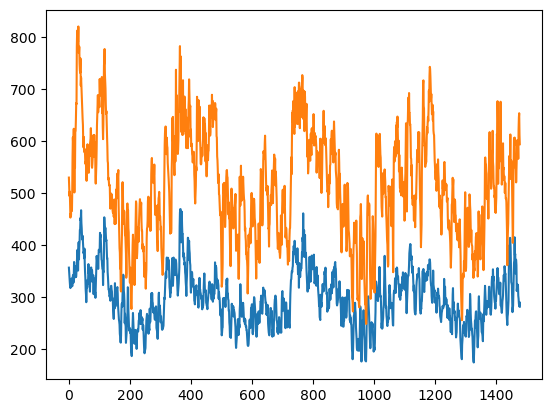

In [6]:
plt.plot(age_2018['forpr_haro3'][6])
plt.plot(age_2018['forpr_ros3'][4])


In [7]:
np.mean(age_2018['forpr_haro3'][6])/24,np.mean(age_2018['forpr_ros3'][4])/24

(12.410099642531781, 21.431791016262512)

### To PR from VS

In [8]:
np.nanmean(age_2018['forpr_haro3'][2])/24,np.mean(age_2018['forpr_ros3'][2])/24

(20.890897190169692, 20.848956946513493)

In [12]:
df = pd.DataFrame(age_2018['forvs_haro3'][2],index=None)
df.to_csv('/ocean/cstang/MOAD/analysis-camryn/combined_from_ariane/age_PRtoadm_haro.csv',index=None)

### Split into seasons

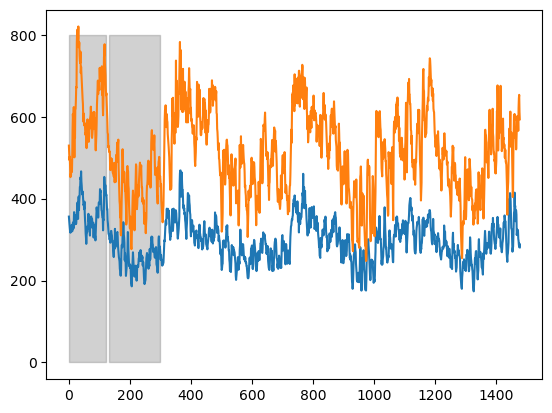

In [13]:
plt.plot(age_2018['forpr_haro3'][6])
plt.plot(age_2018['forpr_ros3'][4])
plt.fill_between([0,120],800,color='dimgrey',alpha=0.3)
plt.fill_between([130,300],800,color='dimgrey',alpha=0.3)


In [28]:
#Both components
np.mean([age_2018['forpr_haro3'][6],age_2018['forgulf_haro3'][7]])/24,np.mean([age_2018['forpr_ros3'][4],age_2018['forpr_ros3'][2]])/24

(11.411823074726444, 21.140373981388)

In [21]:
# Winter
np.mean(age_2018['forpr_haro3'][6][0:120])/24,np.mean(age_2018['forpr_ros3'][4][0:120])/24

(15.034681306109904, 25.970397560677924)

In [24]:
#Both components
np.mean([age_2018['forpr_haro3'][6][0:120],age_2018['forgulf_haro3'][7][0:120]])/24,np.mean([age_2018['forpr_ros3'][4][0:120],age_2018['forpr_ros3'][2][0:120]])/24

(13.828765184950596, 25.232536516063092)

In [22]:
#Summer
np.mean(age_2018['forpr_haro3'][6][130:300])/24,np.mean(age_2018['forpr_ros3'][4][130:300])/24

(10.861301325630313, 18.347165562649945)

In [27]:
#Both components
np.mean([age_2018['forpr_haro3'][6][130:300],age_2018['forgulf_haro3'][7][130:300]])/24,np.mean([age_2018['forpr_ros3'][4][130:300],age_2018['forpr_ros3'][2][130:300]])/24

(9.886304741085459, 18.3082249312846)

#### To adm

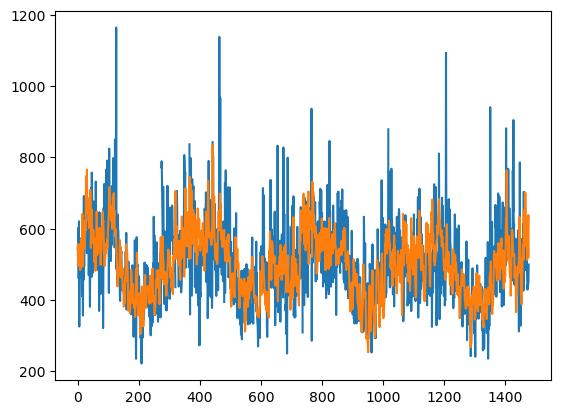

In [16]:
plt.plot(age_2018['forpr_haro3'][2])
plt.plot(age_2018['forpr_ros3'][2])

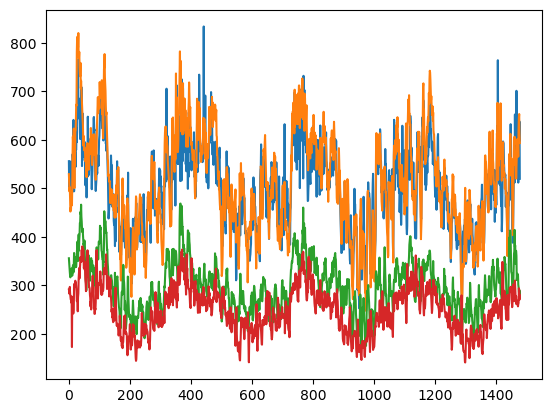

In [19]:
plt.plot(age_2018['forpr_ros3'][2])
plt.plot(age_2018['forpr_ros3'][4])
plt.plot(age_2018['forpr_haro3'][6])
plt.plot(age_2018['forgulf_haro3'][7])